In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
from collections import OrderedDict
import pickle
import networkx as nx
import pygraphviz as pgv
import re

sys.path.insert(0 ,"../codes" )
import IOutils
import draw_moduleRegulation as mr

import matplotlib.pyplot as plt 
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns  
%matplotlib inline
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
plt.rcParams["legend.fontsize"] = "xx-large"

## BK network

In [2]:
###########################
### FILE NAMES
fi_clustGrid = "./correlNetwork_BK/clustMap.pkl"

geneModules_dir = "./correlNetwork_BK/"
geneModules_prefix =  "genes"
geneModules_interest = OrderedDict([ ("genes_blue_3",  "Gene Module 1"  ),  ## These modules were enriched in GO
                                    ("genes_gray_2",  "Gene Module 2" )  ,
                                    ( "genes_green_1" , "Gene Module 3" ),
                                    ("genes_red_3" ,  "Gene Module 4")])

TFmodules_dir = geneModules_dir
TFmodules_prefix = "TFs"
TFmodues_interest  = OrderedDict([ ("TFs_blue_1",  "TF Module 4"  ),#  ## This does not select TF modules but is needed for renaming TF moduels
                                    ("TFs_brown_1",  "TF Module 7" )  ,  #
                                    ( "TFs_purple_1" , "TF Module 8" ),   #
                                    ("TFs_red_1" ,  "TF Module 6"),  #
                                    ("TFs_cyan_1" , "TF Module 5"),  #
                                    ("TFs_blue_2" , "TF Module 9" ) ,  #
                                    ("TFs_pink_1" , "TF Module 10") , ##
                                    ( "TFs_orange_1", "TF Module 11"), #
                                    ("TFs_yellow_1" , "TF Module 2"),  #
                                   ("TFs_orange_2" , "TF Module 3") ,   #
                                     ("TFs_green_1" , "TF Module 1")])  #

fi_expr = "../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl"
fi_stageIDs = "../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv"

###########################
### PARAMETERS
thresh_regMagnitude = 0.05
arrow_scaleFactor = 120
subax_r_plotKws =  {"ci":"sd" }
subax_r_ylabel = "Expression z-score"
kws_insetAxes_r = {"bbox_to_anchor" :(0,0,1,0.85), "width" :"75%", "height":"65%",  }
subax_l_plotKws = { "x" :0.5,  "y": 0.5 , "ha": "center" , "va" : "center", "fontsize" : 12 }
figsize =  (8,7.0 )
subax_r_xlabel_adjust = 0.05
plt.rcParams["axes.labelsize"] = "medium"
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["ytick.labelsize"] = "medium"
plt.rcParams["legend.fontsize"] = "large"

###########################
### Outdir 
outDir = "./correlNetwork_BK/moduleRegFig"

In [3]:
###########################
### LOAD DATA
f = open(fi_clustGrid, 'rb')
clustGrid_data = pickle.load(f)["clustGridData"]
f.close()

## Load modules
fnames_geneModules = [os.path.join(geneModules_dir , x ) for x in os.listdir(geneModules_dir) if x.startswith(geneModules_prefix) ] 
geneModules = mr.loadGeneModules(fnames_geneModules  , lambda x:  os.path.splitext(os.path.basename(x))[0] )

fnames_TFmodules = [os.path.join(TFmodules_dir , x ) for x in os.listdir(TFmodules_dir) if x.startswith(TFmodules_prefix) ] 
TFmodules = mr.loadGeneModules(fnames_TFmodules  , lambda x:  os.path.splitext(os.path.basename(x))[0] )

## Load mean Expr by stage
exprDF = IOutils.loadCellData( fnameDict = OrderedDict([ ("expr", fi_expr ) , ("pcComps" , fi_stageIDs)] ) )
meanByStage = exprDF["expr"].groupby( by = exprDF["rowData"].loc[: , "clust_ID"] ).apply(lambda x: x.mean(axis = 0))
meanByStage_logTpm = np.log10(meanByStage*100 +1 )

## Check that all genes / TFs have been assigned to a module
assert( set().union( *list( geneModules.values()) ) == set(clustGrid_data.index) ) ,  "union gene modules does not equal cluster grid index"
assert( set().union( *list( TFmodules.values()) ) == set(clustGrid_data.columns) ) ,  "union TF modules does not equal cluster grid columns"

loading Files
	loading file ../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl
	loading file ../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv
Summary of Join:
	expr : 22338 of 22338 in join
	pcComps : 22338 of 22338 in join


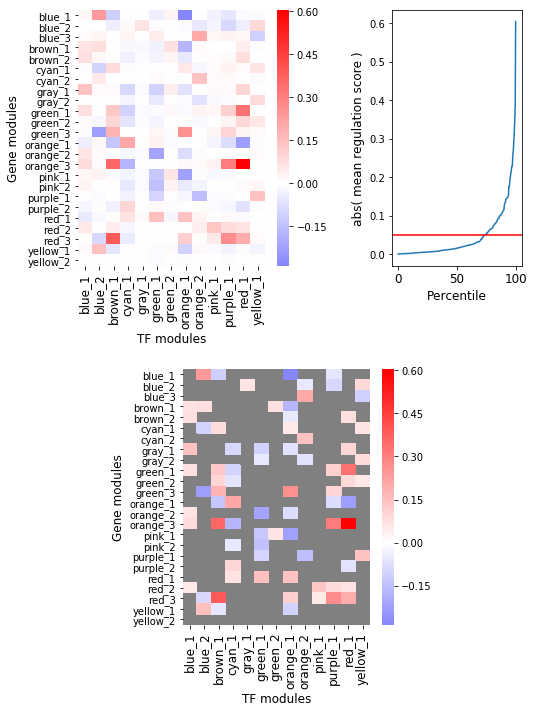

In [4]:
################################################
### Threshold TF gene module regulation scores
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["ytick.labelsize"] = "large"
meanScoreDF = mr.get_meanVal_modulePairs( scoreDF = clustGrid_data.copy() , rowModules= geneModules , colModules =TFmodules )
meanScoreDF_plot = meanScoreDF.rename(columns = lambda x: x[len("TFs_"):], index = lambda x: x[len("genes_"): ] )
fig =mr.make_pairAvgRegFig(meanScoreDF_plot ,
                       thresh_regMagnitude = thresh_regMagnitude, figsize = (7.5, 10),
                        xticklabel_size = 12 , yticklabel_size = 10)

os.makedirs( outDir , exist_ok= True )
fig.savefig( os.path.join(outDir, "avgModulePairReg.pdf") , format = "pdf", bbox_inches = "tight") 

In [5]:
##################
## Setup nodes:
if geneModules_interest is None:
    print("geneModules_intersest is None using all gene modules")
    geneModules_interet= OrderedDict([( x , x) for x in meanScoreDF.index ])
    
nodes_r = list( geneModules_interest.keys() ) 
nodes_l =  [x for x in meanScoreDF.columns if (meanScoreDF.loc[nodes_r, x].abs() >= thresh_regMagnitude).any() ]

score_to_color = lambda x:  "r" if x>=0 else "b"
edges = OrderedDict([ ((node_l , node_r) , {"strength" : arrow_scaleFactor*np.abs(meanScoreDF.loc[ node_r, node_l]) , 
                                              "color" :  score_to_color( meanScoreDF.loc[ node_r, node_l])  } )
                               for node_l in nodes_l 
                                     for node_r in nodes_r   
                                         if np.abs(meanScoreDF.loc[ node_r, node_l]) >= thresh_regMagnitude ])

nodes_l_kws, nodes_r_kws =  mr.getNodeLayout( nodes_l, nodes_r, edgeDict = edges, x_pad = 0.05 , y_pad = 0.05, arrow_pad = 0.15,
                                              ax_pad = 0.01, ax_maxHeight = 0.5 )

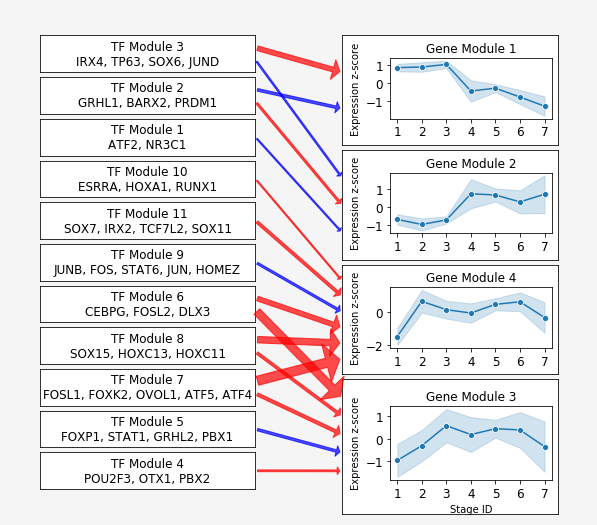

In [6]:
############################
## MAKE FIGURE
plt.rcParams["axes.labelsize"] = "medium"
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["ytick.labelsize"] = "large"
plt.rcParams["legend.fontsize"] = "large"

fig , nodes_set1 , nodes_set2 = mr.makeAxNetwork(nodes_l_kws , nodes_r_kws, edges, figsize= figsize,
                        FancyArrowPatch_kws = dict(arrowstyle = "simple,head_length=0.3,head_width=0.85,tail_width=0.2",
                                                   alpha = 0.7),
                        facecolor = "whitesmoke",
                        strength_to_mut =  lambda x:x  )
for k ,v in nodes_set1.items():
    ax = v["ax"]
    ax = mr.add_moduleText( ax =ax, geneList = TFmodules[k], name = k, moduleName_lookup = TFmodues_interest,
                          text_kws = subax_l_plotKws, wordWrap=5  )
for i ,kv in enumerate( nodes_set2.items()):
    k, v = kv
    ax = v["ax"]
    subax = inset_axes(ax,  bbox_transform =ax.transAxes ,  **kws_insetAxes_r )
    subax = mr.plot_moduleExprByStage(meanByStage_logTpm.copy(), genes = geneModules[k],stages = [1,2,3,4,5,6,7] , ax = subax,
                                    kws_lineplot= subax_r_plotKws ,  xlabel =  " " ,
                                    ylabel = subax_r_ylabel, title = geneModules_interest[k],
                                      title_kws = {'fontsize': 12 } )  ## TO DO. Use different colors for plots\
    if i ==0:
        axPos_old = ax.get_position()
        ax.set_position( (axPos_old.x0 , axPos_old.y0 - subax_r_xlabel_adjust, 
                        axPos_old.width ,  axPos_old.height +  subax_r_xlabel_adjust) )
        subax.set_xlabel("Stage ID")
fig.savefig(os.path.join(outDir , "moduleRegGraph.pdf") , format = "pdf" , bbox_inches = "tight")
## WRITE FILES WITH GENE and TF RENAMING CONVENTION
f =open(os.path.join(outDir , "rename_geneModules.txt"), 'w' )
for k , v in geneModules_interest.items():
    f.write( "{}\t{}\n".format(k , v ))
f.close()

f =open(os.path.join(outDir , "rename_TFmodules.txt"), 'w' )
for k , v in TFmodues_interest.items():
    f.write( "{}\t{}\n".format(k , v ))
f.close()

## DK network

In [2]:
###########################
### FILE NAMES
fi_clustGrid = "./correlNetwork_DK/clustMap.pkl"

geneModules_dir = "./correlNetwork_DK/"
geneModules_prefix =  "genes"
geneModules_interest = OrderedDict([ ("genes_brown_1",  "Gene Module 6"  ), ## These modules were enriched in GO
                                    ("genes_cyan_1",  "Gene Module 1"  ),   
                                    ("genes_gray_1",  "Gene Module 3") ,  
                                    ("genes_purple_1",  "Gene Module 4") ,  
                                   ("genes_yellow_1",  "Gene Module 2") ,  
                                   ("genes_yellow_2",  "Gene Module 5") ,  
                                 ])

TFmodules_dir = geneModules_dir
TFmodules_prefix = "TFs"
TFmodues_interest  = OrderedDict([  ("TFs_brown_1",  "TF Module 5" ), ## This dose not select TF modules but is needed for renaming TF moduels
                                    ("TFs_red_1" ,  "TF Module 4"),   
                                    ("TFs_gray_1" , "TF Module 2" ) , 
                                    ("TFs_pink_1" , "TF Module 1") ,   
                                    ("TFs_yellow_1" , "TF Module 3"),  
                                     ("TFs_green_1" , "TF Module 6")  ])  
                            
fi_expr = "../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl"
fi_stageIDs = "../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv"

###########################
### PARAMETERS
thresh_regMagnitude = 0.05
arrow_scaleFactor = 120
subax_r_plotKws =  {"ci":"sd" }
subax_r_ylabel = "Expression\nz-score"
kws_insetAxes_r = {"bbox_to_anchor" :(0,0,1,0.85) , "width" :"70%", "height":"65%",  }
subax_l_plotKws = { "x" :0.5,  "y": 0.5 , "ha": "center" , "va" : "center", "fontsize" : 14 }
figsize =  (8,7.5 )
subax_r_xlabel_adjust = 0.05
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["ytick.labelsize"] = "medium"
plt.rcParams["legend.fontsize"] = "large"

###########################
### Outdir 
outDir = "./correlNetwork_DK/moduleRegFig"

In [3]:
###########################
### LOAD DATA
f = open(fi_clustGrid, 'rb')
clustGrid_data = pickle.load(f)["clustGridData"]
f.close()

## Load modules
fnames_geneModules = [os.path.join(geneModules_dir , x ) for x in os.listdir(geneModules_dir) if x.startswith(geneModules_prefix) ] 
geneModules = mr.loadGeneModules(fnames_geneModules  , lambda x:  os.path.splitext(os.path.basename(x))[0] )

fnames_TFmodules = [os.path.join(TFmodules_dir , x ) for x in os.listdir(TFmodules_dir) if x.startswith(TFmodules_prefix) ] 
TFmodules = mr.loadGeneModules(fnames_TFmodules  , lambda x:  os.path.splitext(os.path.basename(x))[0] )

## Load mean Expr by stage
exprDF = IOutils.loadCellData( fnameDict = OrderedDict([ ("expr", fi_expr ) , ("pcComps" , fi_stageIDs)] ) )
meanByStage = exprDF["expr"].groupby( by = exprDF["rowData"].loc[: , "clust_ID"] ).apply(lambda x: x.mean(axis = 0))
meanByStage_logTpm = np.log10(meanByStage*100 +1 )

## Check that all genes / TFs have been assigned to a module
assert( set().union( *list( geneModules.values()) ) == set(clustGrid_data.index) ) ,  "union gene modules does not equal cluster grid index"
assert( set().union( *list( TFmodules.values()) ) == set(clustGrid_data.columns) ) ,  "union TF modules does not equal cluster grid columns"

loading Files
	loading file ../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl
	loading file ../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv
Summary of Join:
	expr : 22338 of 22338 in join
	pcComps : 22338 of 22338 in join


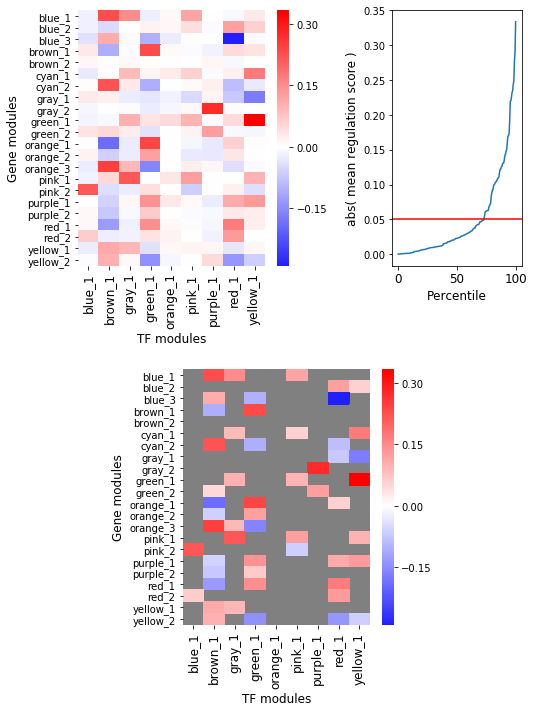

In [4]:
################################################
### Threshold TF gene module regulation scores
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["ytick.labelsize"] = "large"
meanScoreDF = mr.get_meanVal_modulePairs( scoreDF = clustGrid_data.copy() , rowModules= geneModules , colModules =TFmodules )
meanScoreDF_plot = meanScoreDF.rename(columns = lambda x: x[len("TFs_"):], index = lambda x: x[len("genes_"): ] )
fig =mr.make_pairAvgRegFig(meanScoreDF_plot ,
                       thresh_regMagnitude = thresh_regMagnitude, figsize = (7.5, 10),
                        xticklabel_size = 12 , yticklabel_size = 10)

os.makedirs( outDir , exist_ok= True )
fig.savefig( os.path.join(outDir, "avgModulePairReg.pdf") , format = "pdf", bbox_inches = "tight") 

In [5]:
##################
## Setup nodes:
if geneModules_interest is None:
    print("geneModules_intersest is None using all gene modules")
    geneModules_interet= OrderedDict([( x , x) for x in meanScoreDF.index ])
    
nodes_r = list( geneModules_interest.keys() ) 
nodes_l =  [x for x in meanScoreDF.columns if (meanScoreDF.loc[nodes_r, x].abs() >= thresh_regMagnitude).any() ]

score_to_color = lambda x:  "r" if x>=0 else "b"
edges = OrderedDict([ ((node_l , node_r) , {"strength" : arrow_scaleFactor*np.abs(meanScoreDF.loc[ node_r, node_l]) , 
                                              "color" :  score_to_color( meanScoreDF.loc[ node_r, node_l])  } )
                               for node_l in nodes_l 
                                     for node_r in nodes_r   
                                         if np.abs(meanScoreDF.loc[ node_r, node_l]) >= thresh_regMagnitude ])

nodes_l_kws, nodes_r_kws =  mr.getNodeLayout( nodes_l, nodes_r, edgeDict = edges, x_pad = 0.05 , y_pad = 0.05, arrow_pad = 0.15,
                                              ax_pad = 0.01, ax_maxHeight = 0.5 )

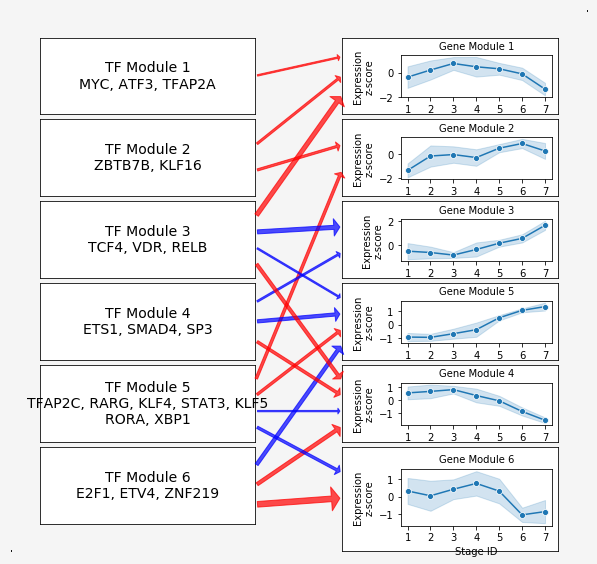

In [6]:
############################
## MAKE FIGURE
plt.rcParams["axes.labelsize"] = "medium"
plt.rcParams["xtick.labelsize"] = "medium"
plt.rcParams["ytick.labelsize"] = "medium"
plt.rcParams["legend.fontsize"] = "large"

fig , nodes_set1 , nodes_set2 = mr.makeAxNetwork(nodes_l_kws , nodes_r_kws, edges, figsize= figsize,
                        FancyArrowPatch_kws = dict(arrowstyle = "simple,head_length=0.3,head_width=0.85,tail_width=0.2",
                                                   alpha = 0.7),
                        facecolor = "whitesmoke",
                        strength_to_mut =  lambda x:x  )
for k ,v in nodes_set1.items():
    ax = v["ax"]
    ax = mr.add_moduleText( ax =ax, geneList = TFmodules[k], name = k, moduleName_lookup = TFmodues_interest,
                          text_kws = subax_l_plotKws, wordWrap=5  )
for i ,kv in enumerate( nodes_set2.items()):
    k, v = kv
    ax = v["ax"]
    subax = inset_axes(ax,  bbox_transform =ax.transAxes ,  **kws_insetAxes_r )
    subax = mr.plot_moduleExprByStage(meanByStage_logTpm.copy(), genes = geneModules[k],stages = [1,2,3,4,5,6,7] , ax = subax,
                                    kws_lineplot= subax_r_plotKws ,  xlabel =  " " ,
                                    ylabel = subax_r_ylabel, title = geneModules_interest[k],
                                      title_kws = {'fontsize': 10 } )  ## TO DO. Use different colors for plots\
    if i ==0:
        axPos_old = ax.get_position()
        ax.set_position( (axPos_old.x0 , axPos_old.y0 - subax_r_xlabel_adjust, 
                        axPos_old.width ,  axPos_old.height +  subax_r_xlabel_adjust) )
        subax.set_xlabel("Stage ID")
fig.savefig(os.path.join(outDir , "moduleRegGraph.pdf") , format = "pdf" , bbox_inches = "tight")
## WRITE FILES WITH GENE and TF RENAMING CONVENTION
f =open(os.path.join(outDir , "rename_geneModules.txt"), 'w' )
for k , v in geneModules_interest.items():
    f.write( "{}\t{}\n".format(k , v ))
f.close()

f =open(os.path.join(outDir , "rename_TFmodules.txt"), 'w' )
for k , v in TFmodues_interest.items():
    f.write( "{}\t{}\n".format(k , v ))
f.close()